# Exercise 2

In the previous exercise we did some data cleaning and data imputation with the data set 
agriRuralDevelopment.csv and through visualization we checked if the cleaning operation was successful.

The goal of the second exercise is to create multiple coordinated views on web pages with the resulting 
file from exercise one, where users can interactively explore the data. For this exercise we only consider 
40 countries of our choosing. 

In [21]:
# imports
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing 
import random
from datetime import datetime

import string
import os

In [13]:
datapath = '../data'
fileName = 'claras_dataframe.csv'

df_ex1 = pd.read_csv(os.path.join(datapath, fileName), index_col=False)
df_ex1.head()

,Unnamed: 0,Country Name,Country Code,year,Agricultural land (% of land area),Agricultural land (sq. km),Arable land (% of land area),Arable land (hectares per person),Arable land (hectares),"Birth rate, crude (per 1,000 people)",...,GDP per capita (current US$),Land area (sq. km),Livestock production index (2004-2006 = 100),"Mortality rate, infant (per 1,000 live births)",Permanent cropland (% of land area),"Population, total",Rural population,Rural population (% of total population),Rural population growth (annual %),Surface area (sq. km)
0,0,Afghanistan,AFG,1960,57.745918,377000.0,11.717673,0.834296,7650000.0,51.279,...,59.773194,652860.0,43.37,232.0,0.076586,8996973.0,8241137.0,91.599,1.589040,652860.0
1,1,Afghanistan,AFG,1961,57.745918,377000.0,11.717673,0.834296,7650000.0,51.373,...,59.860874,652860.0,43.37,232.0,0.076586,9169410.0,8373138.0,91.316,1.589040,652860.0
2,2,Afghanistan,AFG,1962,57.837821,377600.0,11.794259,0.823403,7700000.0,51.457,...,58.458015,652860.0,43.99,232.0,0.091903,9351441.0,8512056.0,91.024,1.645479,652860.0
3,3,Afghanistan,AFG,1963,57.914407,378100.0,11.870845,0.812096,7750000.0,51.530,...,78.706388,652860.0,47.03,227.8,0.091903,9543205.0,8657977.0,90.724,1.699758,652860.0
4,4,Afghanistan,AFG,1964,58.010906,378730.0,11.947431,0.800428,7800000.0,51.589,...,82.095231,652860.0,48.56,223.9,0.111816,9744781.0,8810646.0,90.414,1.747967,652860.0


<Axes: >

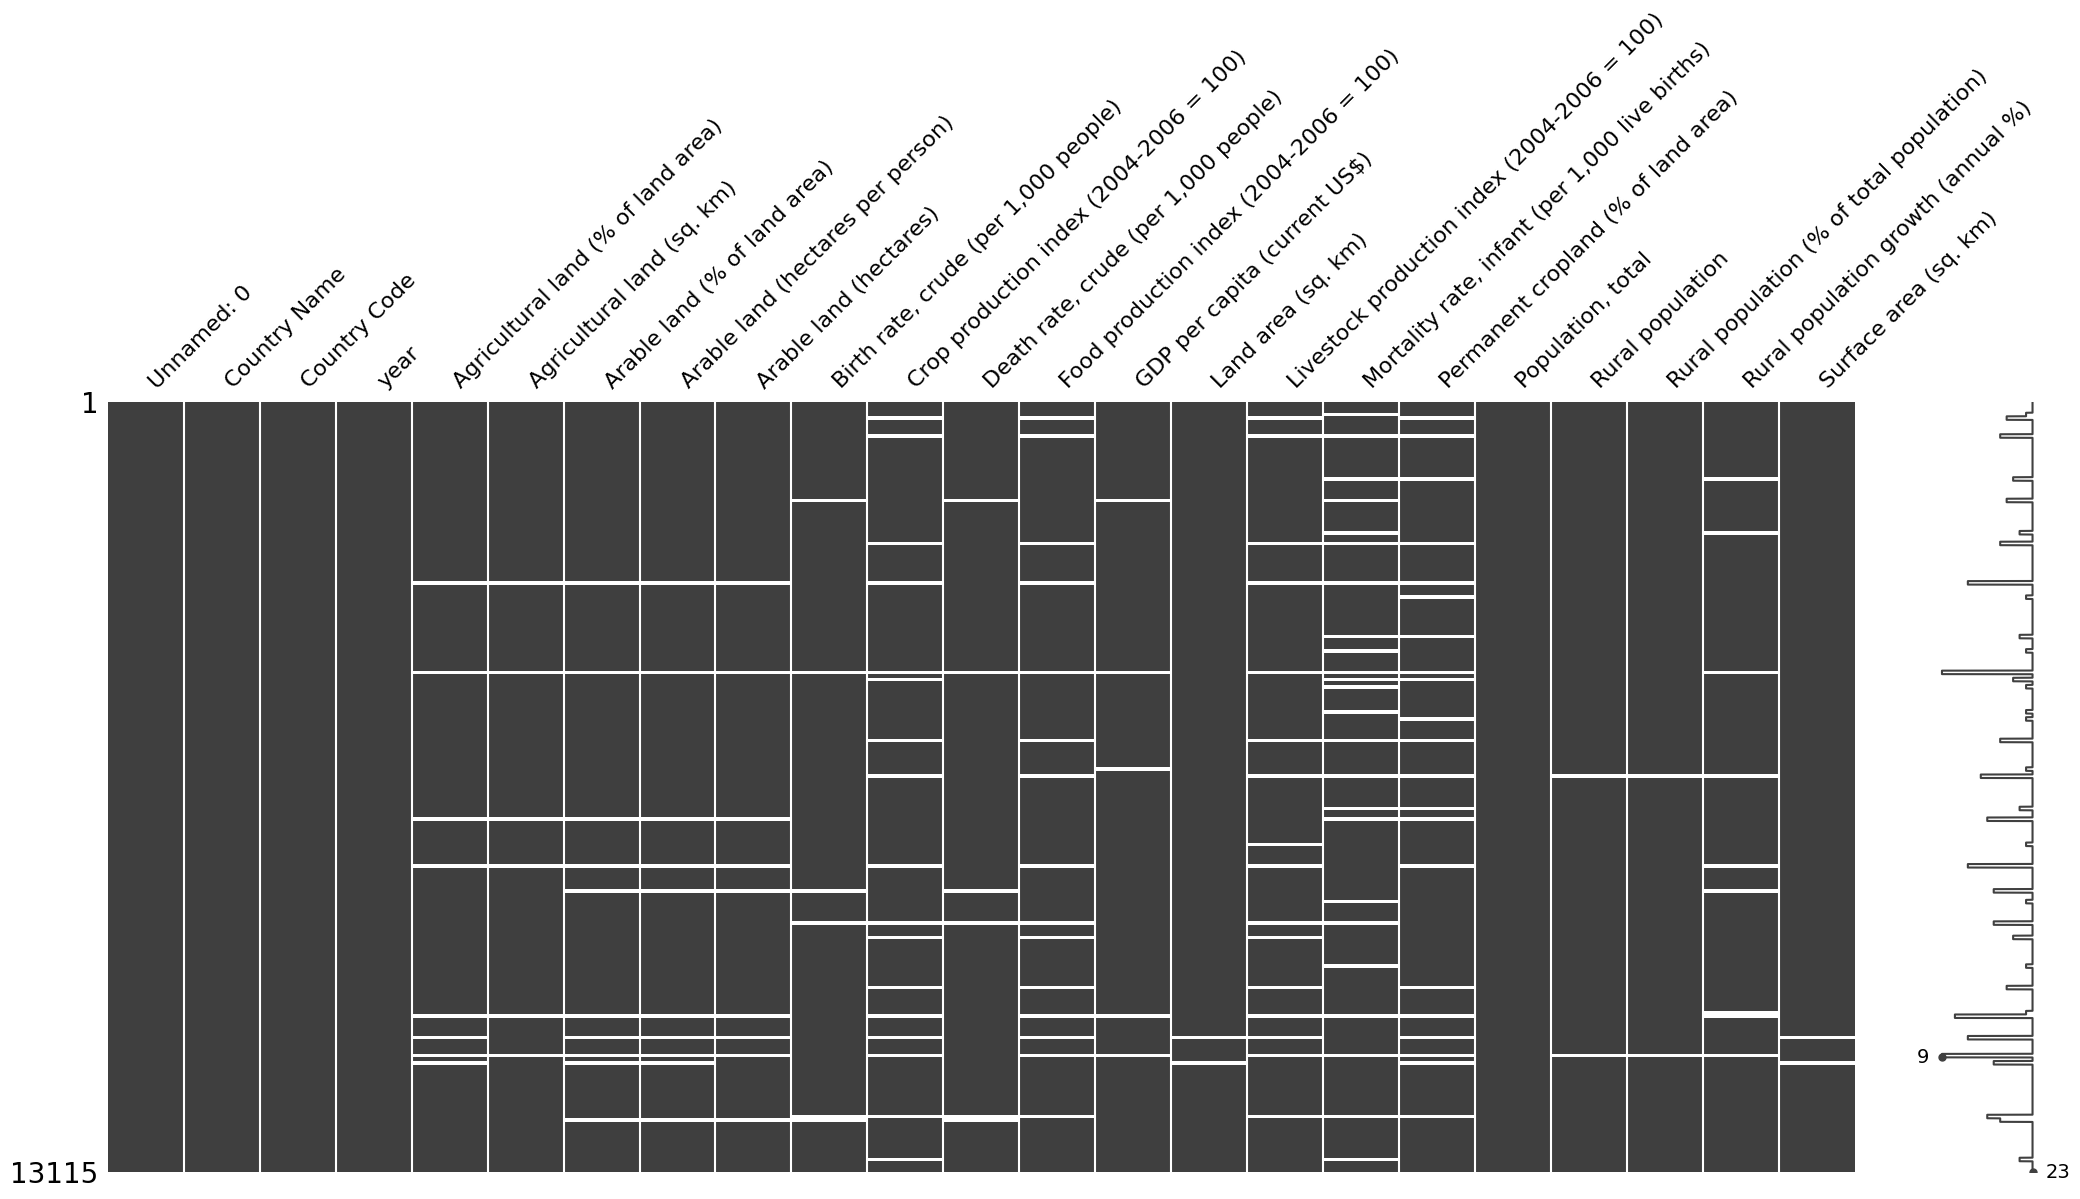

In [6]:
msno.matrix(df_ex1)

## Data Selection

We choose 40 countries of the ones in the dataframe that have no missing values at all. 

/tmp/ipykernel_15594/3313393246.py:12: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(datetime.now())


['Algeria', 'Bosnia and Herzegovina', 'Chad', 'China', 'Congo, Dem. Rep.', 'Czech Republic', 'El Salvador', 'Eritrea', 'Fiji', 'France', 'Guinea-Bissau', 'Guyana', 'Iceland', 'Jamaica', 'Korea, Rep.', 'Kyrgyz Republic', 'Lao PDR', 'Libya', 'Luxembourg', 'Mauritius', 'Mexico', 'Montenegro', 'Mozambique', 'Netherlands', 'New Zealand', 'Nicaragua', 'Niger', 'Papua New Guinea', 'Puerto Rico', 'Russian Federation', 'Senegal', 'Solomon Islands', 'Sri Lanka', 'Syrian Arab Republic', 'Togo', 'Turkey', 'United Kingdom', 'Uruguay', 'Vietnam', 'Yemen, Rep.']


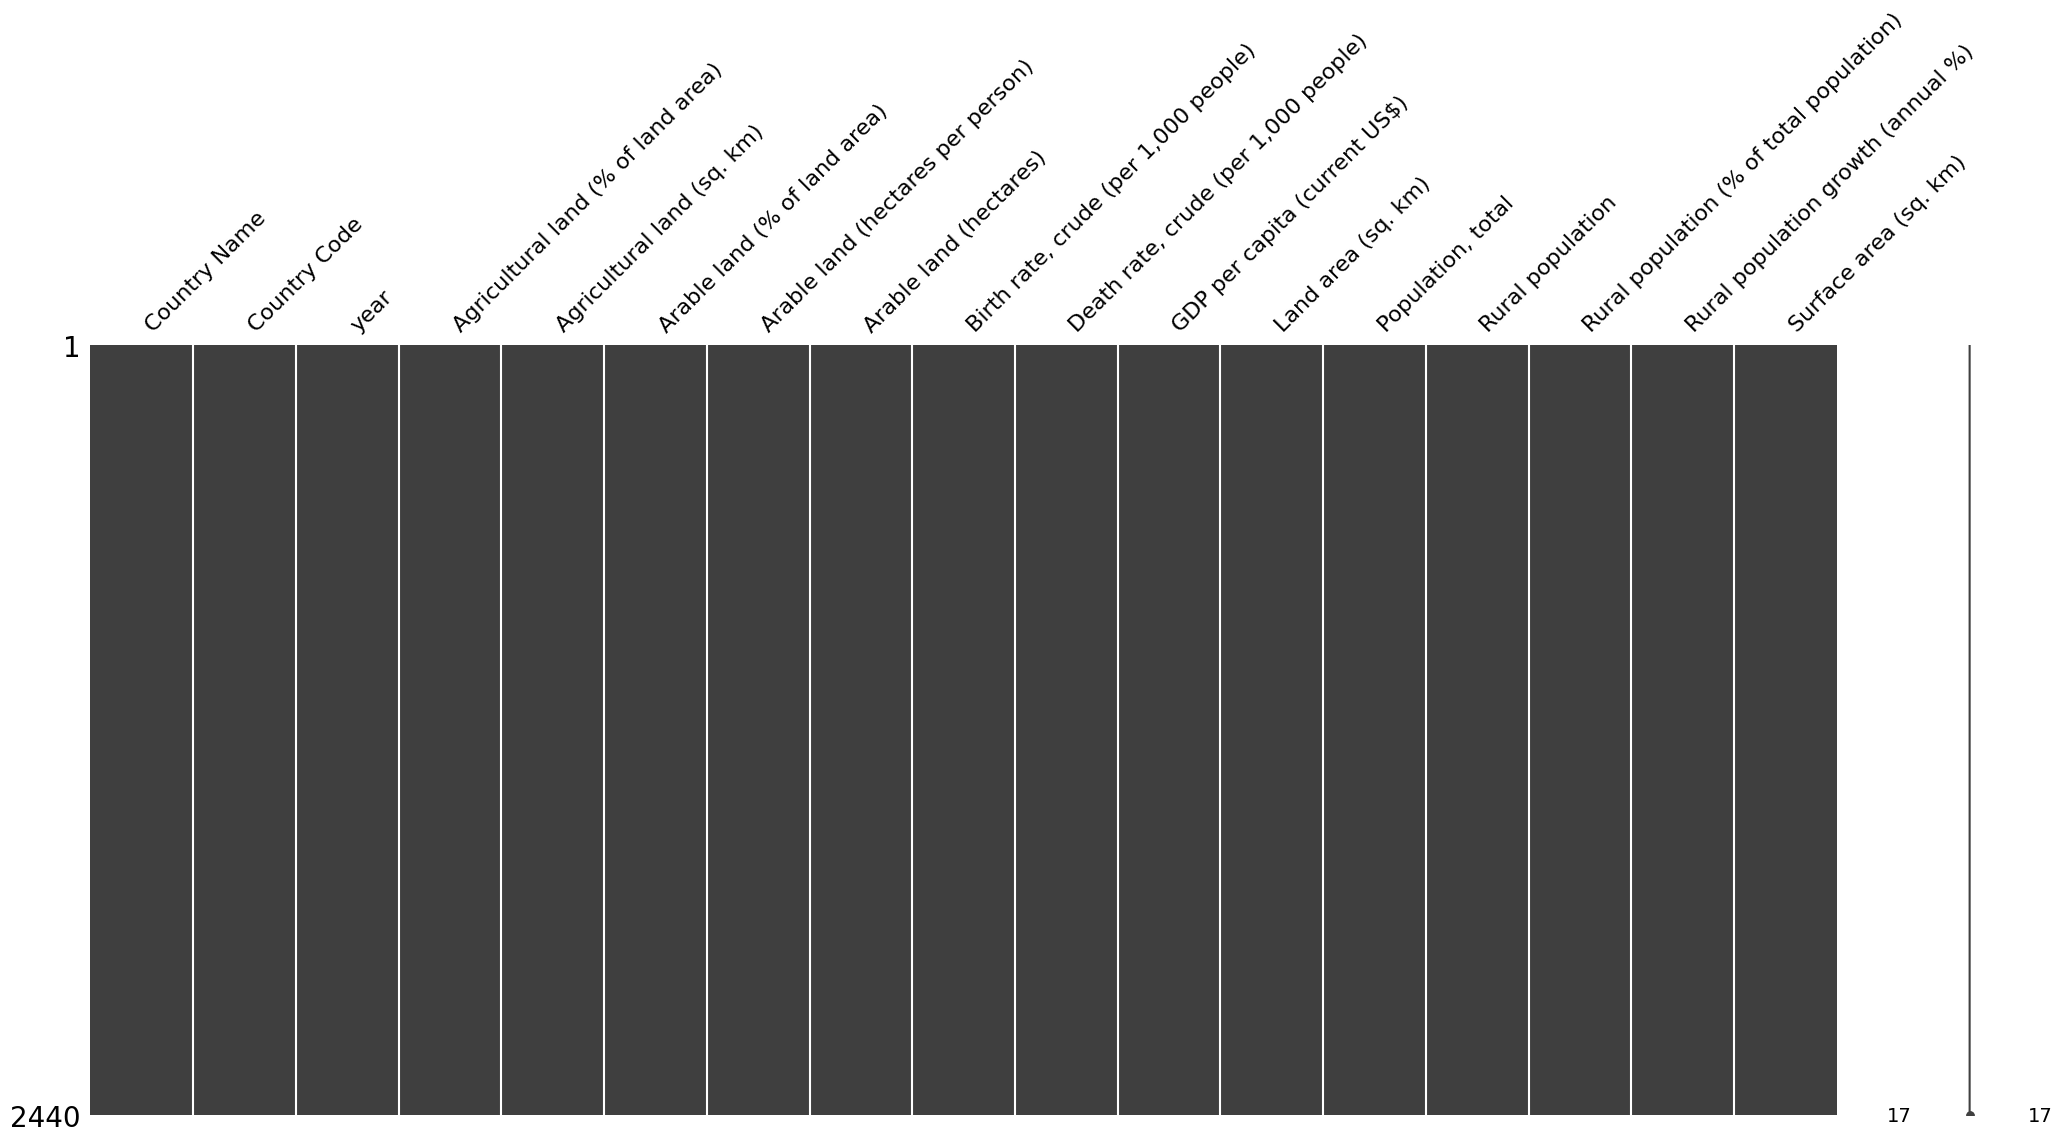

In [24]:
from urllib.request import urlopen
import json
url = 'https://gist.githubusercontent.com/bquast/944781aa6dcc257ebf9aeee3c098b637/raw/871039f36e7b277a20d34619d72ec6b62957fe28/world-topo.json'
known_codes = []
with urlopen(url) as response:
    world_map = json.load(response)
    countries = world_map['objects']['countries']['geometries']
    for country in countries:
        known_codes.append(country['properties']['id'])


random.seed(datetime.now())

df_selected = df_ex1.drop(df_ex1.columns[[0, 10, 12, 15, 16, 17]], axis=1).copy()
list1 = list(df_selected['Country Name'].unique())
list2 = list(df_selected['Country Code'].unique())
dictionary = dict(zip(list1, list2))
country_names = sorted(list(set(df_selected["Country Name"])))
cn_selected = [cn for cn in country_names if df_selected[df_selected["Country Name"] == cn].isnull().sum().sum() == 0]
cn_selected = [country for country in cn_selected if dictionary[country] in known_codes]
cn_selected = random.sample(cn_selected, 40)

df_selected40 = df_selected.loc[df_selected['Country Name'].isin(cn_selected)]

msno.matrix(df_selected40)
print(sorted(cn_selected))

df_selected40.to_csv('../data/preproc_claras_dataframe.csv')


## PCA - Principle Component Analysis

PCA, or Principal component analysis, is the main linear algorithm for dimension reduction often used in unsupervised learning.
This algorithm identifies and discards features that are less useful to make a valid approximation on a dataset.

By reducing the number of features, PCA can help:
- Reduce the risk of overfitting a model to noisy features.
- Speed-up the training of a machine learning algorithm
- Make simpler data vizualisations.

In [273]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

def PrComAnalysis(df, string):
    df_2020 = df[df["year"] == 2020].copy()

    # distributing the dataset into two components X and Y
    tmp = list(df_2020.columns)
    tmp.remove(string)
    tmp.remove('Country Name')
    tmp.remove('Country Code')
    tmp.remove('year') 

    # distributing the dataset into two components X and y
    # We decided to do the regression on Agricultural land (% of land area)
    X = df_2020[tmp].values 
    y =  df_2020.loc[:,[string]].values

    # fitting the Standard scale
    X_scaled = preprocessing.scale(X)

    # Create a PCA object and fit it to the data
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X_scaled)

    df_PCA = pd.DataFrame(data = principalComponents, index = df_2020['Country Code'].values
                          , columns = ['PC1', 'PC2'])
    
    return df_PCA



PrComAnalysis(df_selected40, 'Agricultural land (% of land area)')
PrComAnalysis(df_selected40, "Rural population")

,PC1,PC2
ARG,9.371433,1.890826
BHR,-1.495949,-0.739280
BRN,-1.775014,0.817782
BGR,-0.272300,3.074447
BFA,0.483323,-1.973698
BDI,-0.389320,-2.831613
CPV,-1.444227,0.263308
KHM,-0.327541,-1.040982
CMR,0.664940,-0.927072
CIV,0.573401,-1.409566


In [12]:
df_selected40.columns.values

print("""'Country Name', 'Country Code', 'year',
       'Agricultural land (% of land area)', 'Agricultural land (sq. km)',
       'Arable land (% of land area)',
       'Arable land (hectares per person)', 'Arable land (hectares)',
       'Birth rate, crude (per 1,000 people)',
       'Death rate, crude (per 1,000 people)',
       'GDP per capita (current US$)', 'Land area (sq. km)',
       'Population, total', 'Rural population',
       'Rural population (% of total population)', 'Rural population growth (annual %)', 'Surface area (sq. km)'""".replace('  ', '').replace('\n', ''))

'Country Name', 'Country Code', 'year', 'Agricultural land (% of land area)', 'Agricultural land (sq. km)', 'Arable land (% of land area)', 'Arable land (hectares per person)', 'Arable land (hectares)', 'Birth rate, crude (per 1,000 people)', 'Death rate, crude (per 1,000 people)', 'GDP per capita (current US$)', 'Land area (sq. km)', 'Population, total', 'Rural population', 'Rural population (% of total population)', 'Rural population growth (annual %)', 'Surface area (sq. km)'


In [14]:
set(df_selected40['Country Code'])

{'AFG',
 'ATG',
 'AUT',
 'AZE',
 'BEL',
 'BGR',
 'BHR',
 'BRN',
 'CAF',
 'CHN',
 'CIV',
 'COD',
 'COG',
 'CUB',
 'DMA',
 'DZA',
 'ECU',
 'ESP',
 'GIN',
 'GTM',
 'HND',
 'HRV',
 'JAM',
 'KAZ',
 'KNA',
 'LAO',
 'LBR',
 'LBY',
 'LSO',
 'LTU',
 'MDG',
 'MLT',
 'MNE',
 'MYS',
 'NOR',
 'THA',
 'UKR',
 'URY',
 'YEM',
 'ZMB'}

## Time Series

<Axes: xlabel='year'>

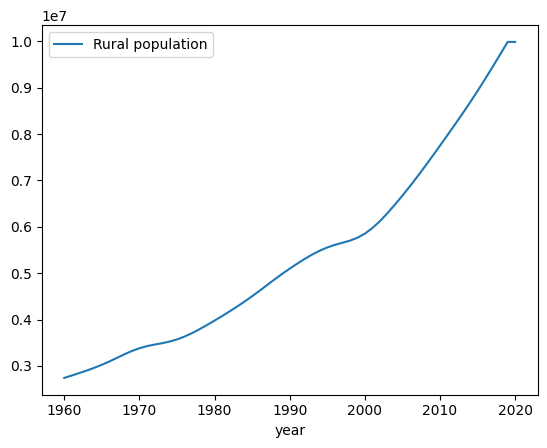

In [269]:
def timeSeries(df, country, attr):
    df_tmp = df[df["Country Name"]== country][["year", attr]].copy()
    return df_tmp.reset_index(drop=True)



timeSeries(df_selected40, "Burundi", "Rural population").plot(x="year", y="Rural population")
    

In [266]:
df_selected40[df_selected40["Country Name"]=='Burundi'][["year","Rural population"]].reset_index(drop=True).head()

,year,Rural population
0,1960,2739819.0
1,1961,2792109.0
2,1962,2844697.0
3,1963,2899417.0
4,1964,2958713.0


## Data Imputation

As mentioned in the feedback of exercise 1, it is not recommended to use for every attribute the same data imputation method. The matrix above shows us that we are still missing some values in all columns except for five. The first column are just indizies which we can clearly drop without consequences. 

For the columns Surface area (sq. km), Land area (sq. km),  Agricultural land (sq. km), Arable land (hectares), Rural population we will use the closest value method.
For columns like Agricultural land (% of land area), Arable land (% of land area), Arable land (hectares per person), Rural population (% of total population) we can calculate the values with two other columns.
Mortality rate, infant (per 1,000 live births), Birth rate, crude (per 1,000 people) ... etc maybe just mode /most frequent


In [ ]:
df_ex1.head()
df_ex1.isnull().sum()
df_ex1.isnull().mean()*100

In [161]:
df_imputed = df_ex1.drop(df_ex1.columns[0], axis=1).copy()               # [0, 10, 12, 15, 16, 17]
country_names = sorted(list(set(df_imputed["Country Name"])))

mode_imputer = SimpleImputer(strategy='most_frequent')
knn_imputer = KNNImputer(n_neighbors=4)

colm_closestval = {"Surface area (sq. km)", 
                   "Agricultural land (sq. km)", 
                   "Arable land (hectares)", 
                   "Rural population" }

colm_mode =  {"Mortality rate, infant (per 1,000 live births)", 
              "Death rate, crude (per 1,000 people)",  
              "Birth rate, crude (per 1,000 people)"}

groups = [df_imputed[df_imputed["Country Name"] == cn] for cn in country_names]

# apply imputation to each column for each group
imputed_groups = []
for group in groups:
    imputed_group = pd.DataFrame()
    for col in group.columns:
        if col in colm_closestval:
            imputer = knn_imputer 
        elif col in colm_mode:
            imputer = mode_imputer
        else:
            continue
        imputed_col = imputer.fit_transform(group[[col]])
        #imputed_group[col] = imputed_col.flatten()
        group.iloc[:, group.columns.get_loc(col)] = imputed_col.flatten()
    imputed_groups.append(imputed_group)

# combine imputed groups into a single DataFrame
imputed_df = pd.concat(imputed_groups)

/var/folders/k8/k2brnsnj5jj9l2034hkmzgqw0000gn/T/ipykernel_27719/1029812888.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group.iloc[:, group.columns.get_loc(col)] = imputed_col.flatten()
/var/folders/k8/k2brnsnj5jj9l2034hkmzgqw0000gn/T/ipykernel_27719/1029812888.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group.iloc[:, group.columns.get_loc(col)] = imputed_col.flatten()
/var/folders/k8/k2brnsnj5jj9l2034hkmzgqw0000gn/T/ipykernel_27719/1029812888.py:31: SettingWithCopyWarning: 
A value is try

ValueError: Must have equal len keys and value when setting with an iterable

<Axes: >

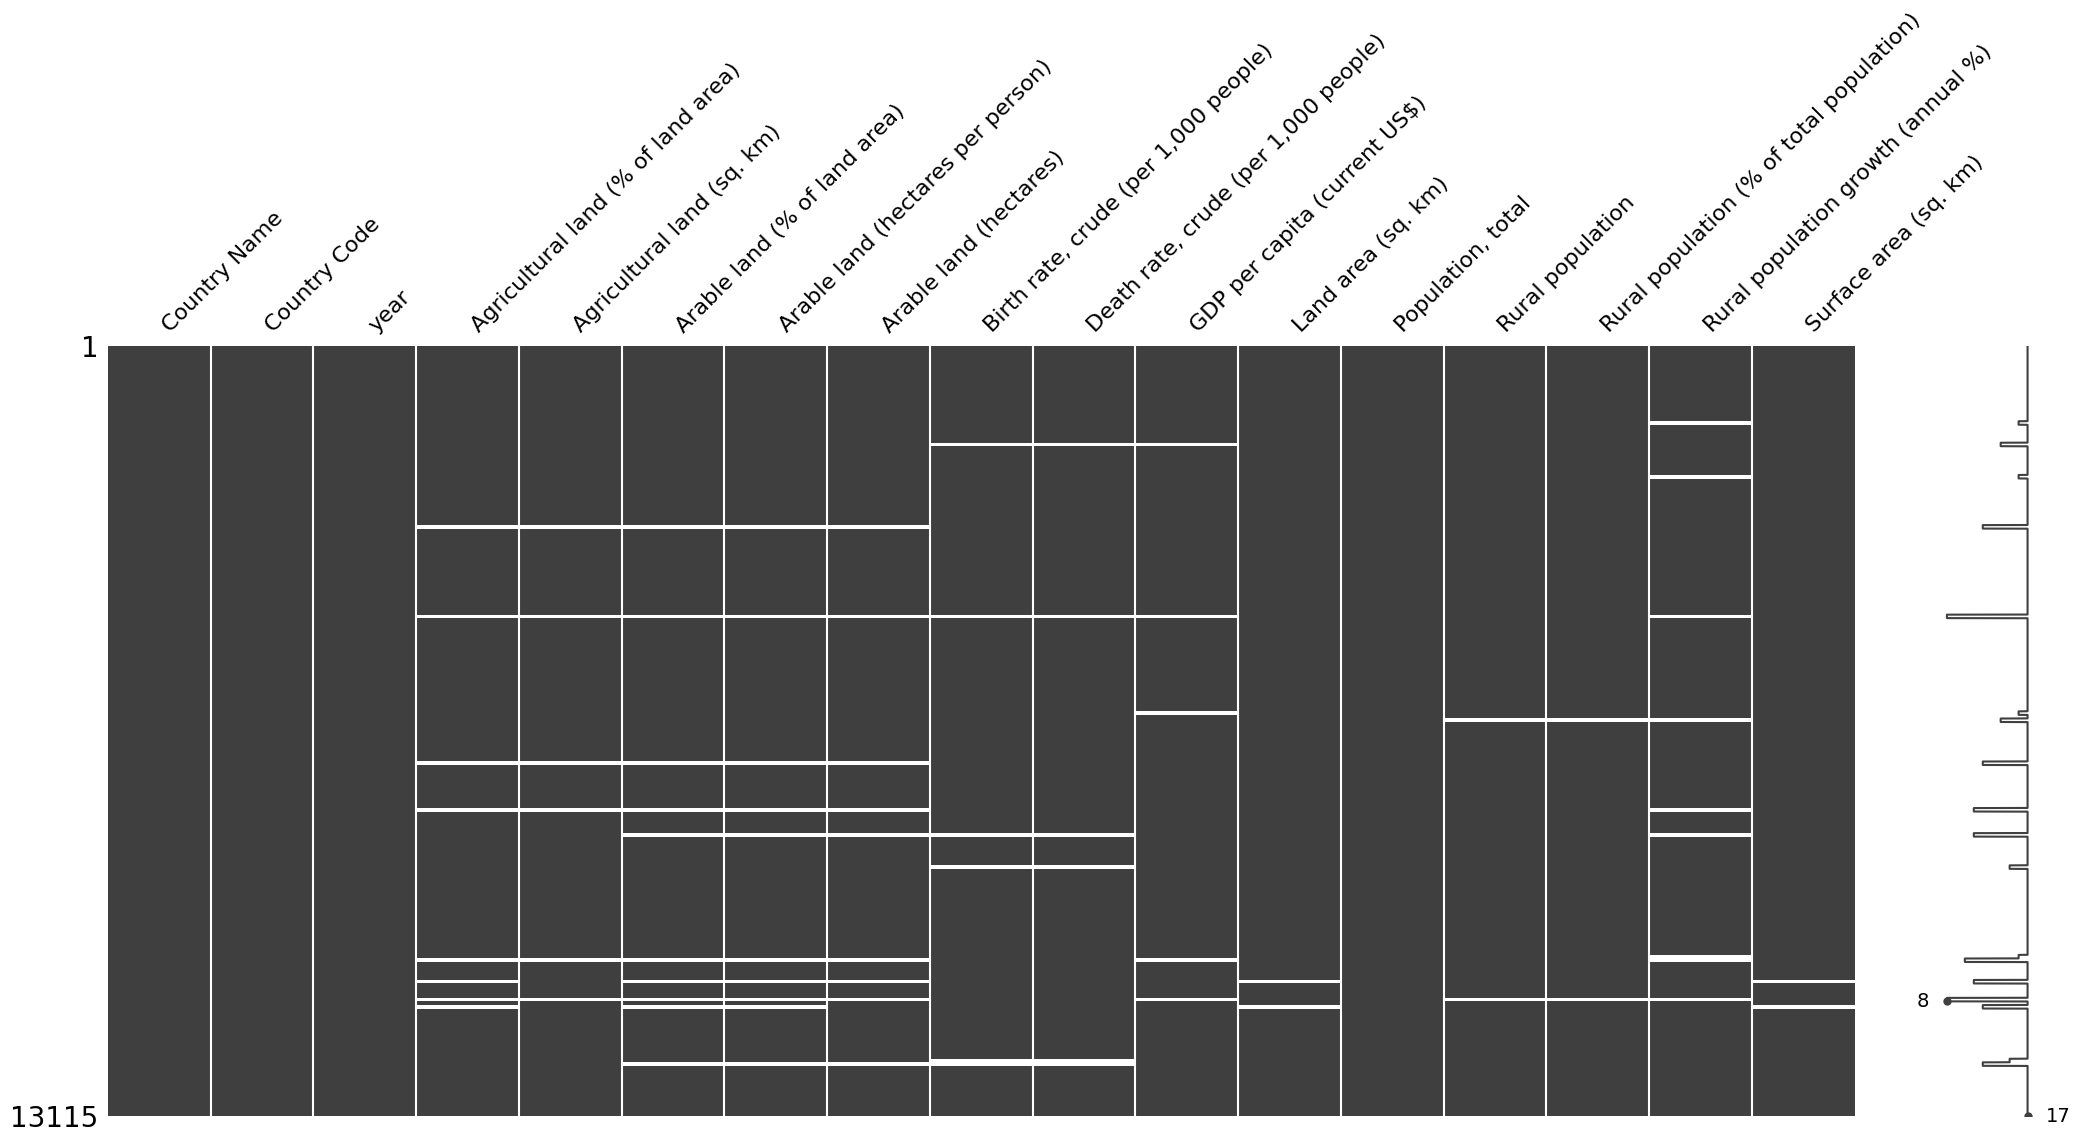

In [33]:
msno.matrix(df_imputed)